In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
path = "/kaggle/input/second-hand-car-price-prediction/cars.csv"

cars_data = pd.read_csv(path)
cars_data.head(10)

,Car_ID,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,1,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5,800000
1,2,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5,1000000
2,3,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4,2500000
3,4,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5,600000
4,5,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5,850000
5,6,Tata,Nexon,2019,35000,Petrol,Manual,First,17,1198,108,5,750000
6,7,Mahindra,Scorpio,2018,45000,Diesel,Automatic,Second,15,2179,140,7,900000
7,8,Volkswagen,Polo,2020,25000,Petrol,Automatic,First,18,999,76,5,650000
8,9,Audi,A4,2017,30000,Diesel,Automatic,First,18,1968,187,5,2200000
9,10,BMW,X1,2019,20000,Diesel,Automatic,Second,20,1995,190,5,2700000


In [3]:
cars_data.shape

(100, 13)

In [4]:
# Check rows with missing targets
cars_data['Price'].isna().sum()

0

In [5]:
X_data = cars_data.copy()
y_data = X_data.Price
X_data.drop(['Price'], axis=1, inplace=True)
X_data.head()

,Car_ID,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,1,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5
1,2,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5
2,3,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4
3,4,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5
4,5,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5


It means that all rows have targets, so we don't need to delete any row

In [6]:
# Delete the Car_ID column, since the purpose of it is only ordering the rows
X_data.drop(['Car_ID'], axis=1, inplace=True)
X_data.head()

,Brand,Model,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Toyota,Corolla,2018,50000,Petrol,Manual,First,15,1498,108,5
1,Honda,Civic,2019,40000,Petrol,Automatic,Second,17,1597,140,5
2,Ford,Mustang,2017,20000,Petrol,Automatic,First,10,4951,395,4
3,Maruti,Swift,2020,30000,Diesel,Manual,Third,23,1248,74,5
4,Hyundai,Sonata,2016,60000,Diesel,Automatic,Second,18,1999,194,5


# Linear Regression

In [7]:
# Break off validation data from training data
from sklearn.model_selection import train_test_split

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_data, y_data, train_size=0.7,
                                                     test_size=0.3, random_state=0)

In [8]:
# Identify categoricl and numerical columns:
# Select categorical cols
categorical_cols = [cname for cname in X_train_full.columns if
                   X_train_full[cname].nunique() < 15 and
                   X_train_full[cname].dtype == "object"]
categorical_cols

['Brand', 'Fuel_Type', 'Transmission', 'Owner_Type']

In [9]:
# Select numerical cols
numerical_cols = [cname for cname in X_train_full.columns if
                 X_train_full[cname].dtype in ['int64', 'float64']]
numerical_cols

['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']

We are missing the Brand model, let's analyize to check how many unique values we have on it

In [10]:
X_train_full['Model'].unique()

array(['Verna', 'Tigor', 'Tiago', 'Aspire', 'Venue', 'X3', '5 Series',
       '3 Series', 'Passat', 'A3', 'Civic', 'Altroz', 'Santro', 'Sonata',
       'City', 'Q3', 'Ranger', 'GLE', 'Nexon', 'XUV300', 'EcoSport',
       'Corolla', 'WR-V', 'E-Class', 'Mustang', 'Endeavour', 'Ameo',
       'C-Class', 'Elantra', 'X5', 'Safari', 'Q7', 'Ertiga', 'GLC',
       'Fortuner', 'Camry', 'Innova', 'Yaris', '7 Series', 'S-Cross',
       'Innova Crysta', 'Creta', 'Figo', 'T-Roc', 'X1', 'A6', 'BR-V'],
      dtype=object)

In [11]:
X_train_full['Model'].nunique()

47

Due the the high cardinality of Model column, for now we won't consider this column. Later we'll include it to see its effect in the performance of the model

In [12]:
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [13]:
X_train.head()

,Brand,Fuel_Type,Transmission,Owner_Type,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
60,Hyundai,Petrol,Automatic,Second,2019,24000,17,1497,113,5
80,Tata,Diesel,Manual,First,2018,42000,24,1047,69,5
90,Tata,Petrol,Manual,First,2020,18000,23,1199,84,5
68,Ford,Petrol,Manual,Third,2019,26000,20,1194,94,5
51,Hyundai,Petrol,Manual,Third,2018,32000,17,1197,81,5


Use of pipelines

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

#Preprocessing for numerical data:
numerical_transformer = SimpleImputer(strategy='constant')

#Preprocessing for categorical data:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing for numericcal and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#Define model
model = LinearRegression()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model
clf.fit(X_train, y_train)

# Get predictions
preds = clf.predict(X_valid)

mae_1 = mean_absolute_error(y_valid, preds)

print('MAE', mae_1)

MAE 225599.80981168922


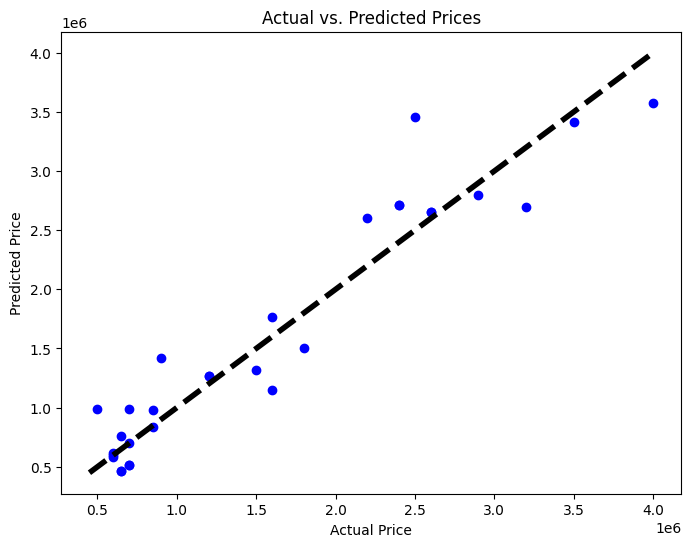

In [15]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, preds, color='blue')  # Scatter plot of actual vs predicted
plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=4)  # Diagonal line where actual = predicted
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()

# Linear Regression including the 'Model' column

In [16]:
# Add the model column to categorical
if not 'Model' in categorical_cols:
    categorical_cols.append('Model')
    
categorical_cols

['Brand', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Model']

In [17]:
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

#Preprocessing for numerical data:
numerical_transformer = SimpleImputer(strategy='constant')

#Preprocessing for categorical data:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing for numericcal and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#Define model
model = LinearRegression()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model
clf.fit(X_train, y_train)

# Get predictions
preds = clf.predict(X_valid)

mae_2 = mean_absolute_error(y_valid, preds)

print('MAE', mae_2)

MAE 163282.30405668318


Out Mean Absolute Error improve 

In [19]:
mae_improvement = mae_1 - mae_2
mae_improvement

62317.505755006045

In [20]:
mae_improvement_percentage = mae_improvement / mae_1
mae_improvement_percentage

0.27623031157261696

**Our Mean Absolute Error reduced around 62317, which means a reduction of 27.6% respet to the initial value.**

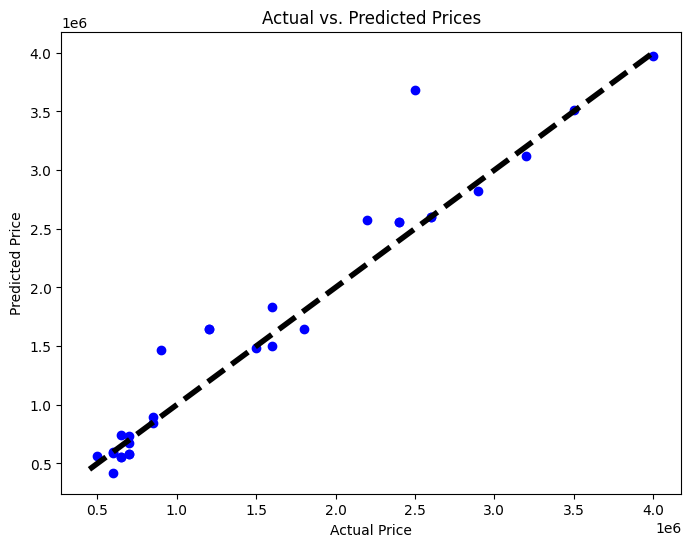

In [21]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, preds, color='blue')  # Scatter plot of actual vs predicted
plt.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=4)  # Diagonal line where actual = predicted
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()

# Linear Regression Adding StandarScaler to the Pipeline preprocesssing

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

#Preprocessing for numerical data:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')), 
    ('scaler', StandardScaler())
])

#Preprocessing for categorical data:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Bundle preprocessing for numericcal and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#Define model
model = LinearRegression()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model
clf.fit(X_train, y_train)

# Get predictions
preds = clf.predict(X_valid)

mae_3 = mean_absolute_error(y_valid, preds)

print('MAE', mae_3)

MAE 168425.5458671553


**Just comparing the previous MAE with the current, the result is a little worse. So we just keep our model without the use of StandarScaler.**